# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import roc_auc_score

#from imblearn.over_sampling import SMOTE
import lightgbm
from lightgbm import LGBMClassifier
#import catboost
#from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

# Data Size Shrinkage Helper Function

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Read Data

In [3]:
invoice_test = pd.read_csv('invoice_test.csv',low_memory=False)
print(f'invoice_test has {invoice_test.shape[0]:,} rows and {invoice_test.shape[1]} cols','\n')

invoice_train = pd.read_csv('invoice_train.csv',low_memory=False)
print(f'invoice_train has {invoice_train.shape[0]:,} rows and {invoice_train.shape[1]} cols','\n')


invoice_test has 1,939,730 rows and 16 cols 

invoice_train has 4,476,749 rows and 16 cols 



In [4]:
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [5]:
client_test = pd.read_csv('client_test.csv',low_memory=False)
print(f'client_test has {client_test.shape[0]:,} rows and {client_test.shape[1]} cols','\n')

client_train = pd.read_csv('client_train.csv',low_memory=False)
print(f'client_train has {client_train.shape[0]:,} rows and {client_train.shape[1]} cols','\n')

client_test has 58,069 rows and 5 cols 

client_train has 135,493 rows and 6 cols 



In [6]:
sub=pd.read_csv('SampleSubmission.csv')

# EDA

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


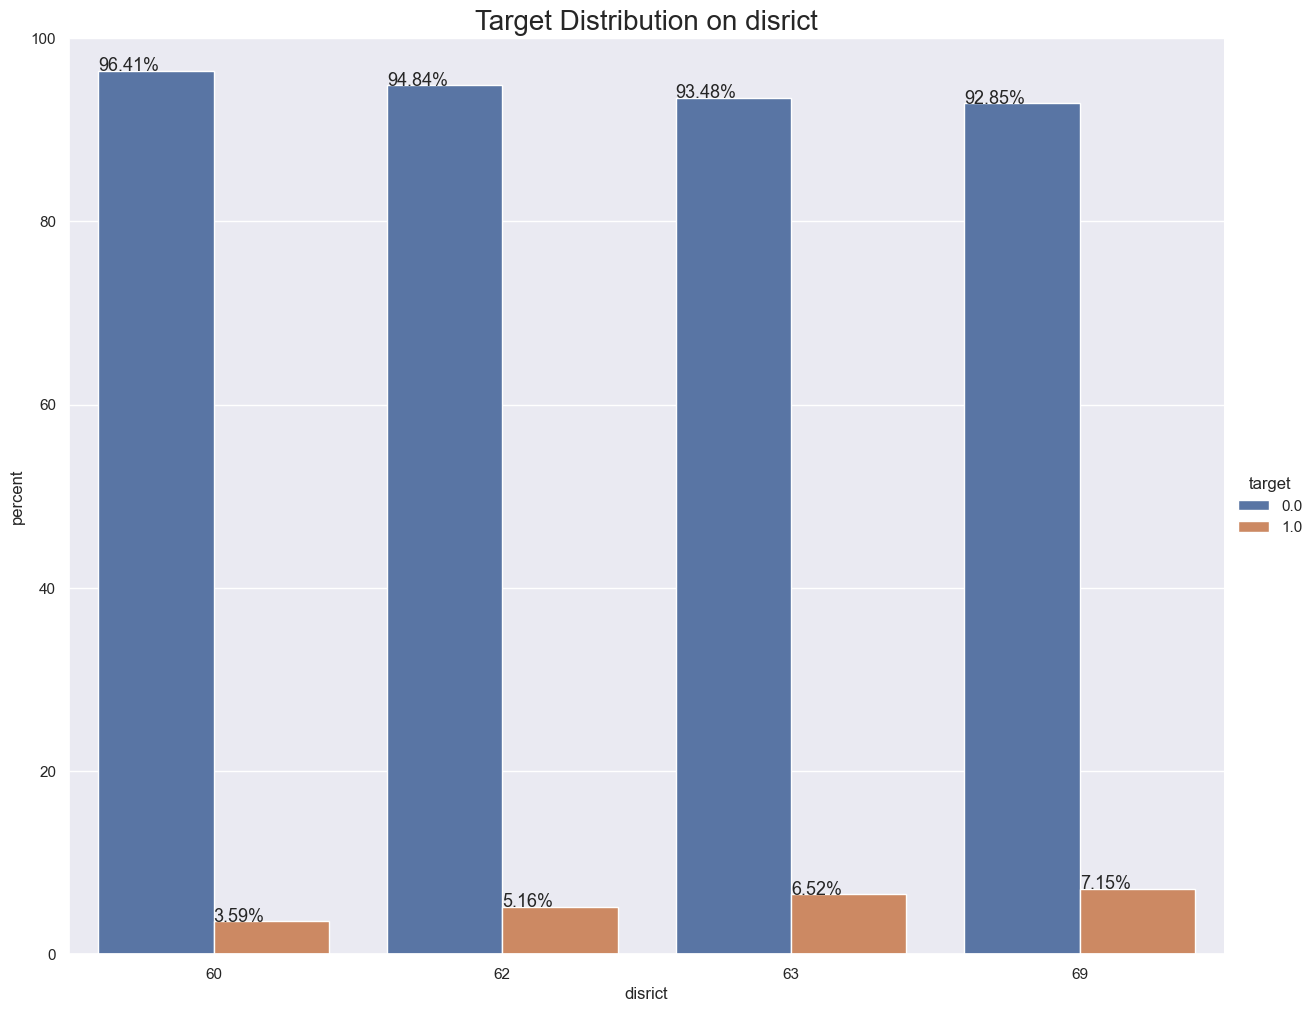

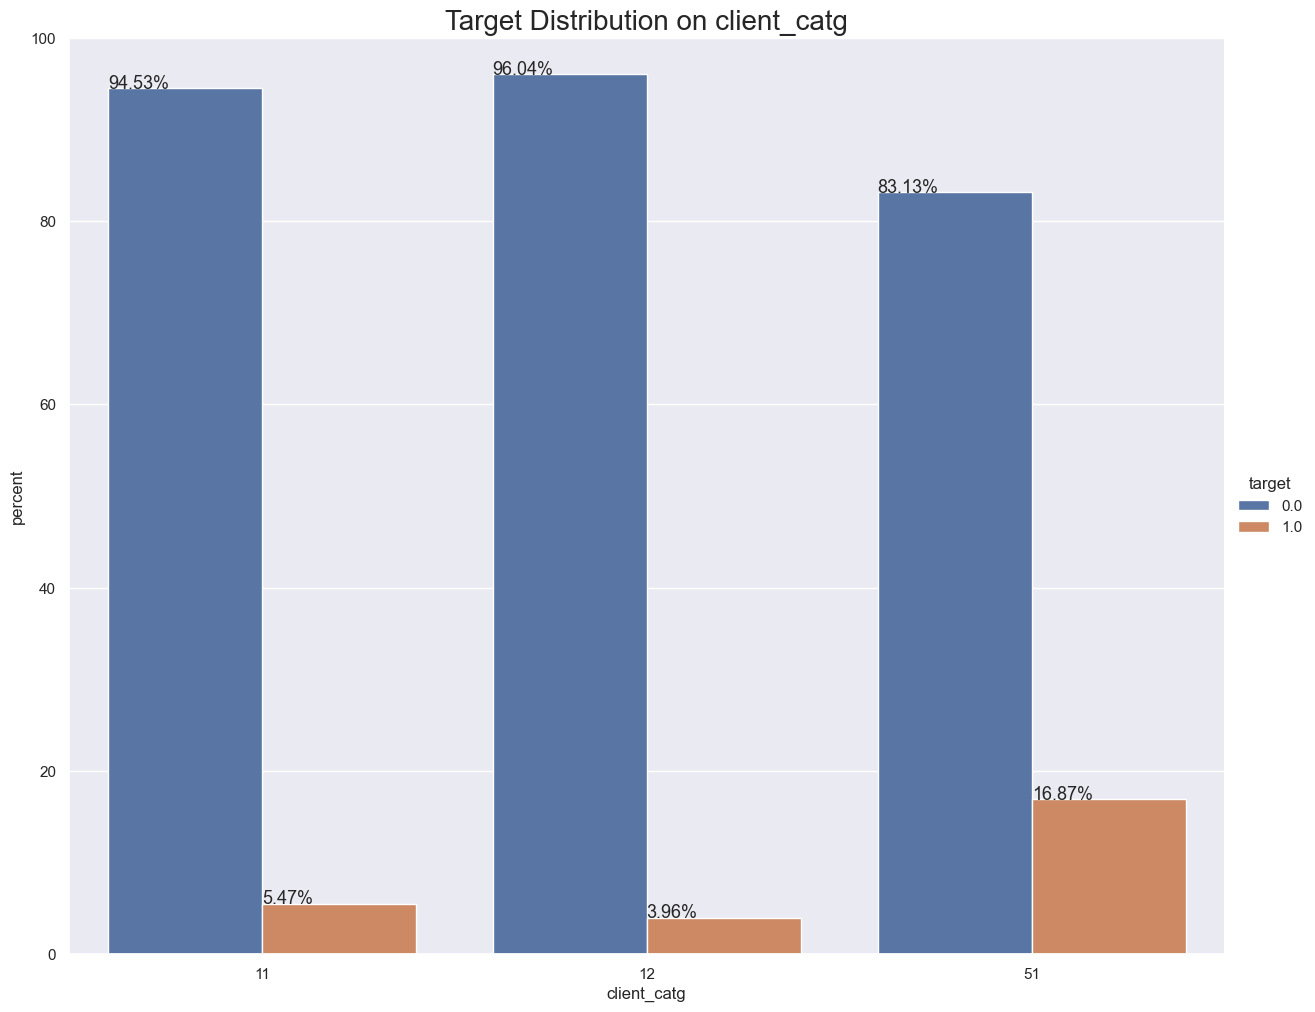

posx and posy should be finite values
posx and posy should be finite values


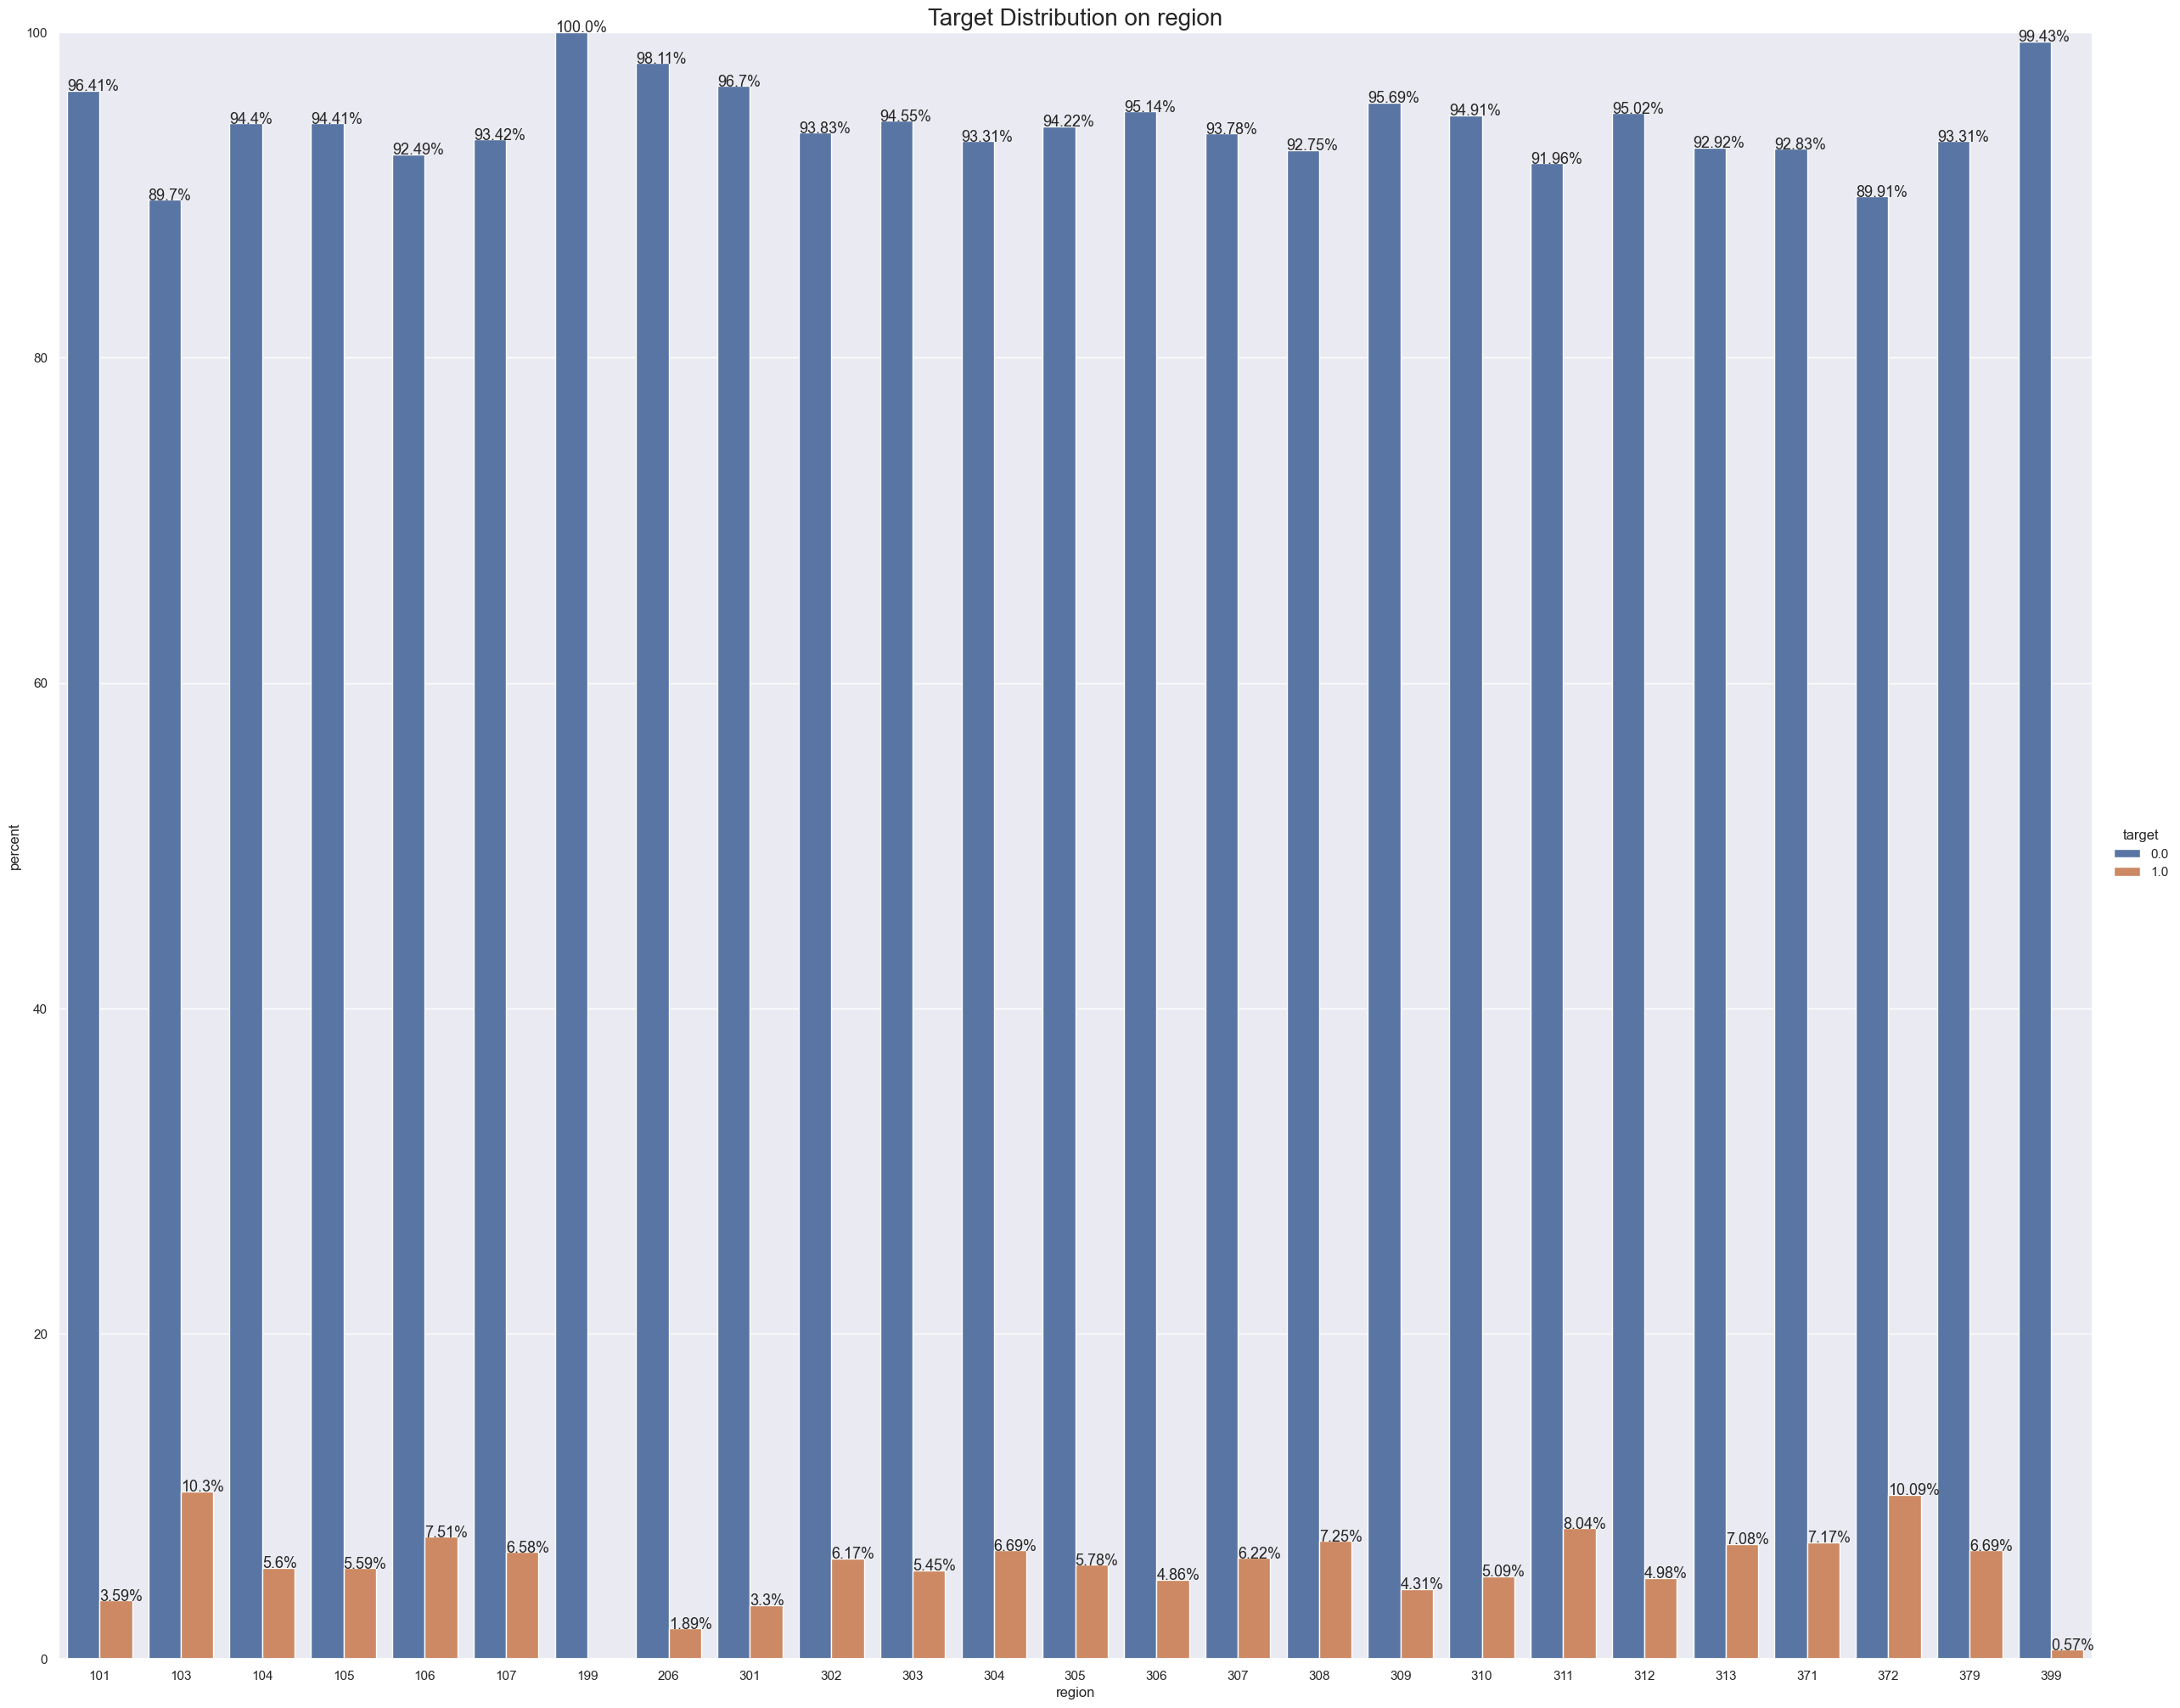

In [7]:
all_x = ['disrict','client_catg','region']
y = 'target'

for x in all_x:
    df1 = client_train.groupby(x)[y].value_counts(normalize=True)
    df1 = df1.mul(100)
    df1 = df1.rename('percent').reset_index()
    
    if x == 'region':
        height = 20
    else:
        height = 10
    g = sns.catplot(x=x,y='percent',hue=y,kind='bar',data=df1,height = height, aspect = 1.25)
    g.ax.set_title(f'Target Distribution on {x}',fontsize=20)
    g.ax.set_ylim(0,100)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt, size=13)
        
    figure = g.fig   
    figure.savefig(f'Target Distribution on {x}.jpg',format='jpeg',
                   dpi=100,
                   bbox_inches='tight')

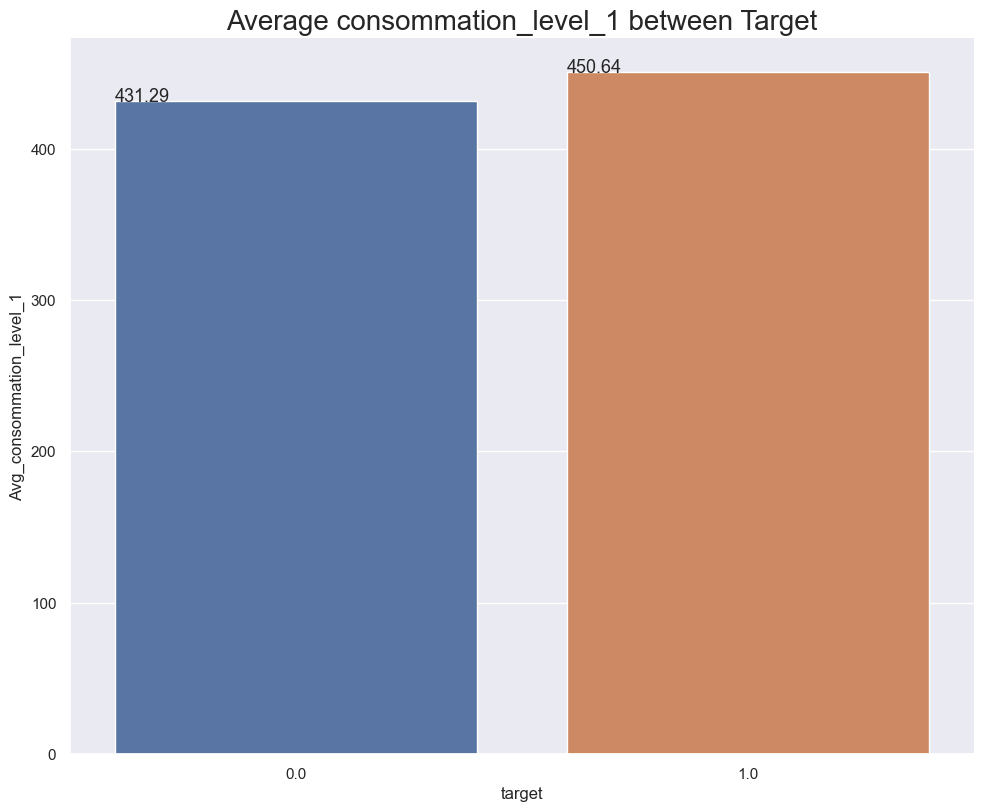

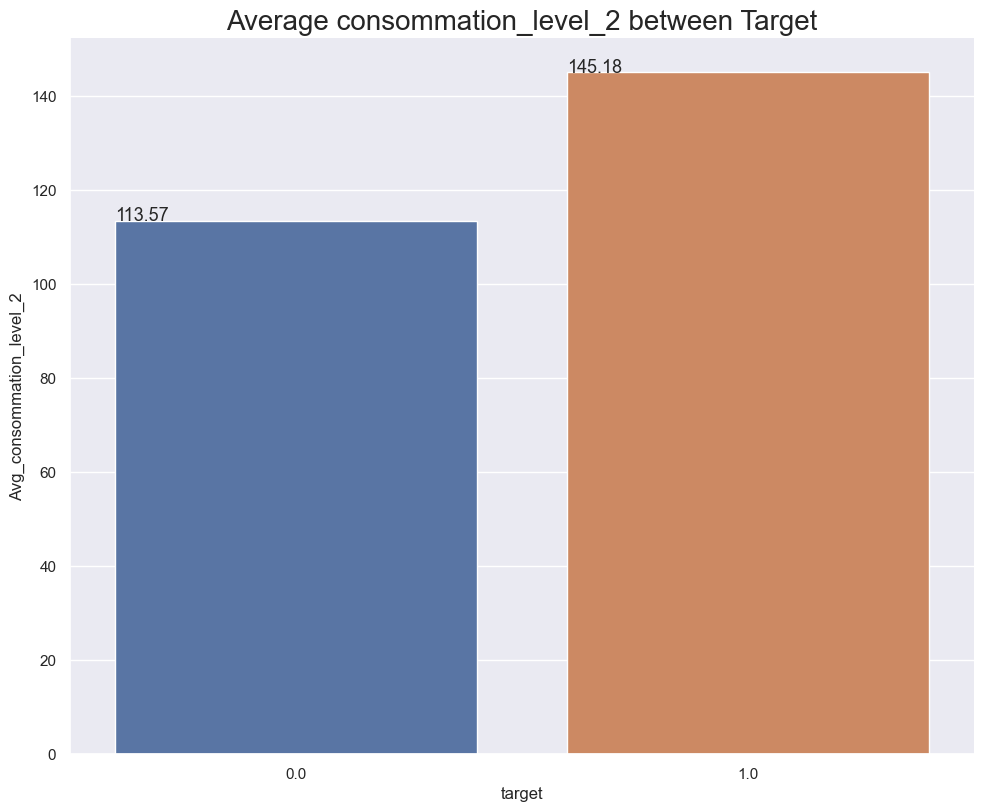

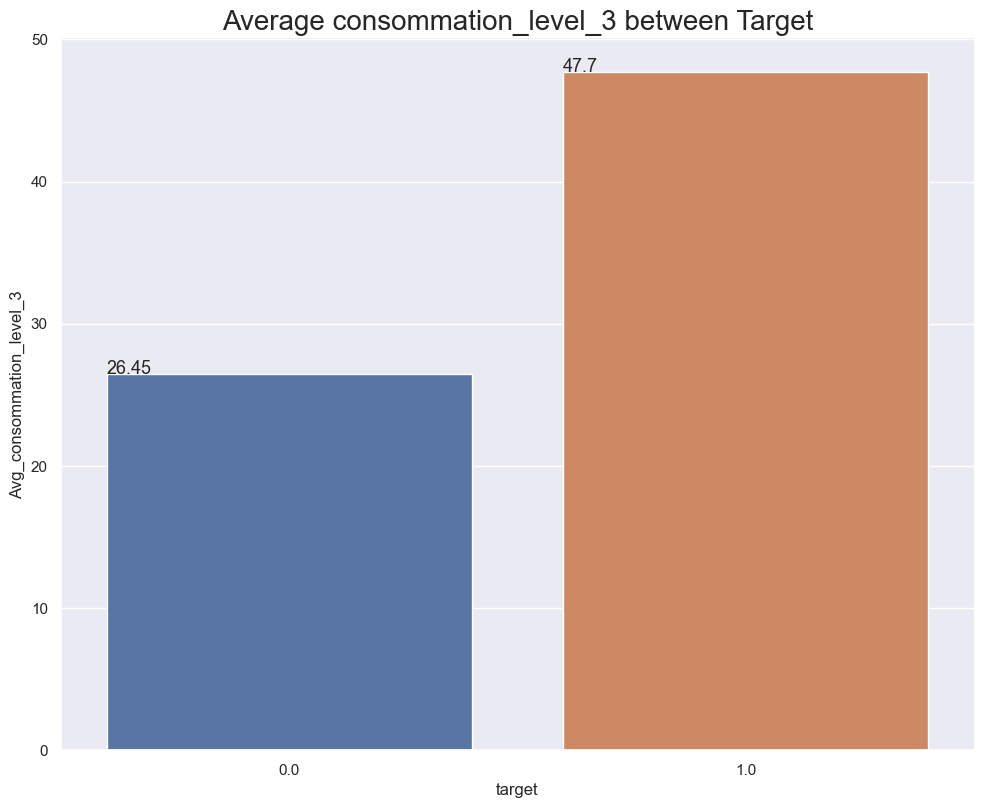

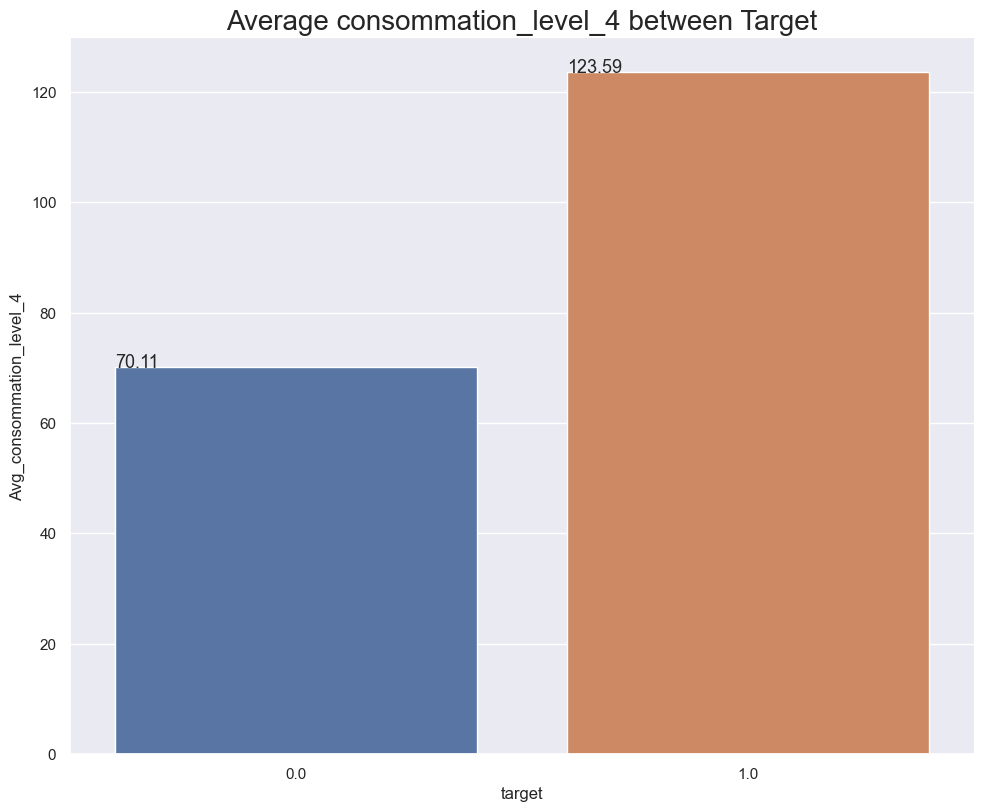

In [8]:
df_merge = client_train.merge(invoice_train.groupby(['client_id']).agg({'consommation_level_1':np.mean,
                                          'consommation_level_2':np.mean,
                                          'consommation_level_3':np.mean,
                                          'consommation_level_4':np.mean}).reset_index(),
                         how='inner',on='client_id')
consommations = ['consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4']

for consommation in consommations:
    df1 = df_merge.groupby(['target'])[consommation].mean().rename(f'Avg_{consommation}').reset_index()
    
    g = sns.catplot(x='target',y=f'Avg_{consommation}',kind='bar',data=df1,height = 8, aspect = 1.25)
    g.ax.set_title(f'Average {consommation} between Target',fontsize=20)

    for p in g.ax.patches:
        txt = str(p.get_height().round(2))
        txt_x = p.get_x()
        txt_y = p.get_height()
        g.ax.text(txt_x,txt_y,txt, size=13)
    
    figure = g.fig   
    figure.savefig(f'Average {consommation} between Target.jpg',format='jpeg',
                   dpi=100,
                   bbox_inches='tight')

# Data Cleansing

Bad counter_statue and remarque

In [9]:
cate_cols = ['counter_statue','reading_remarque']

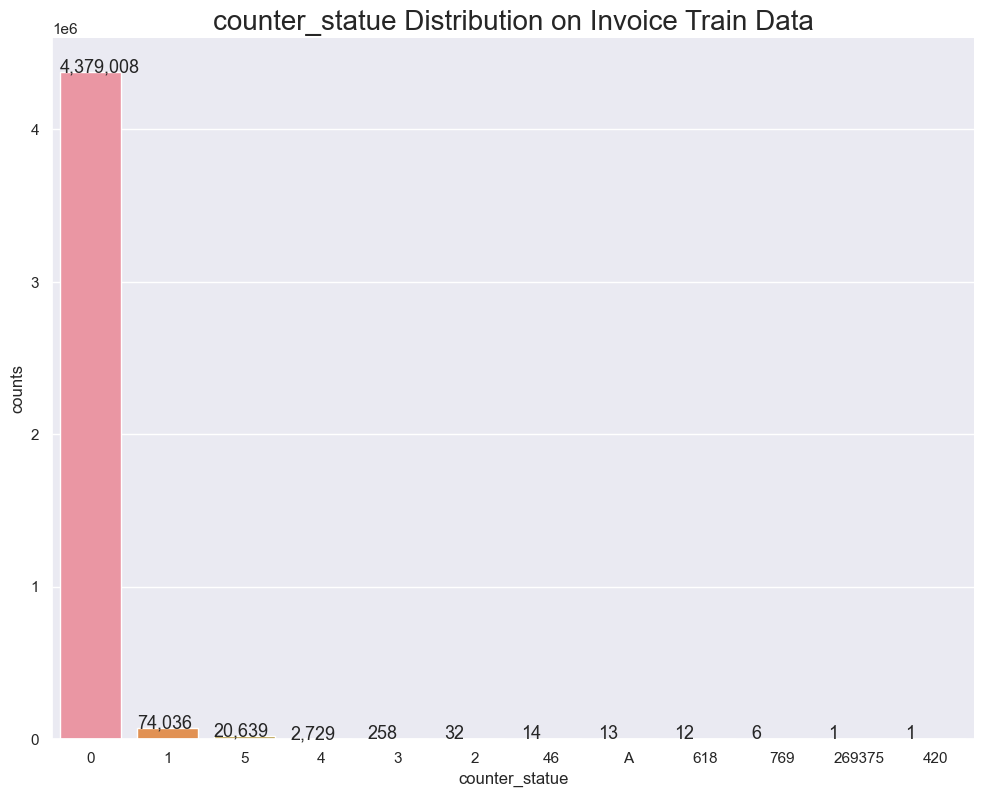

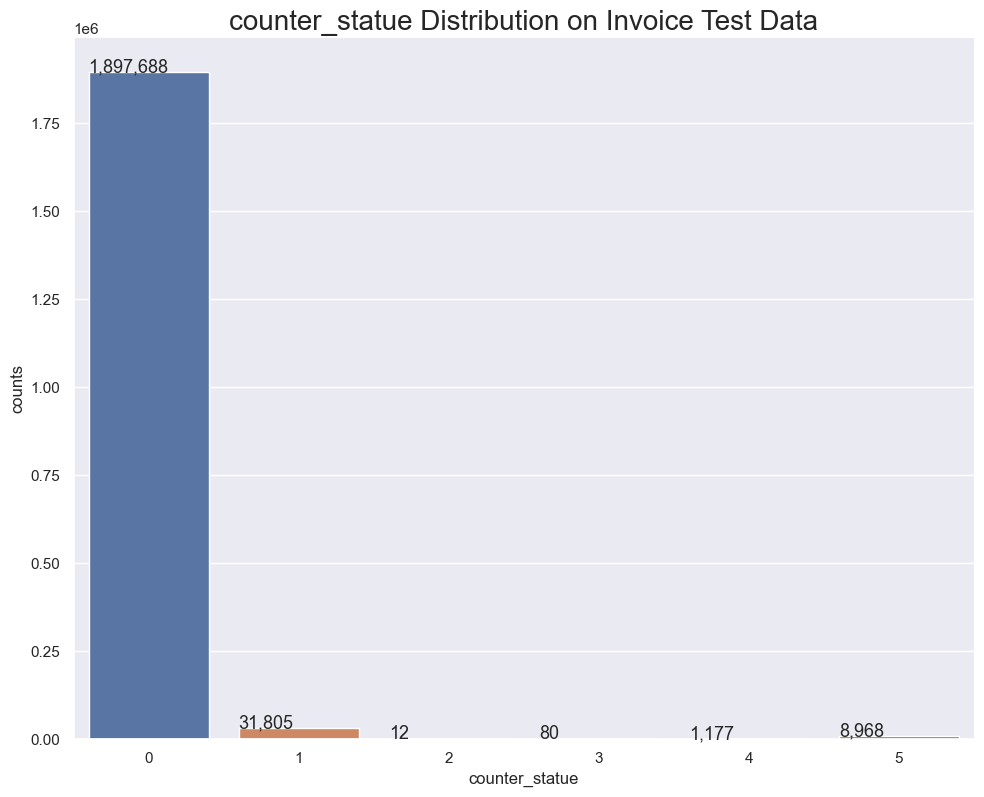

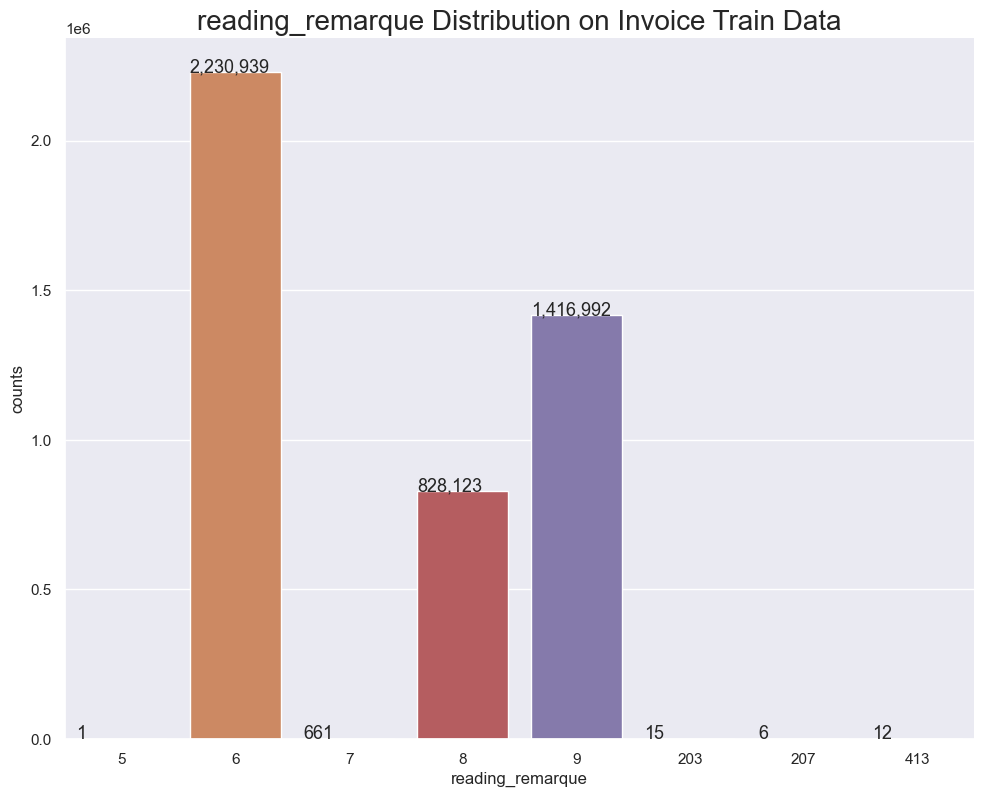

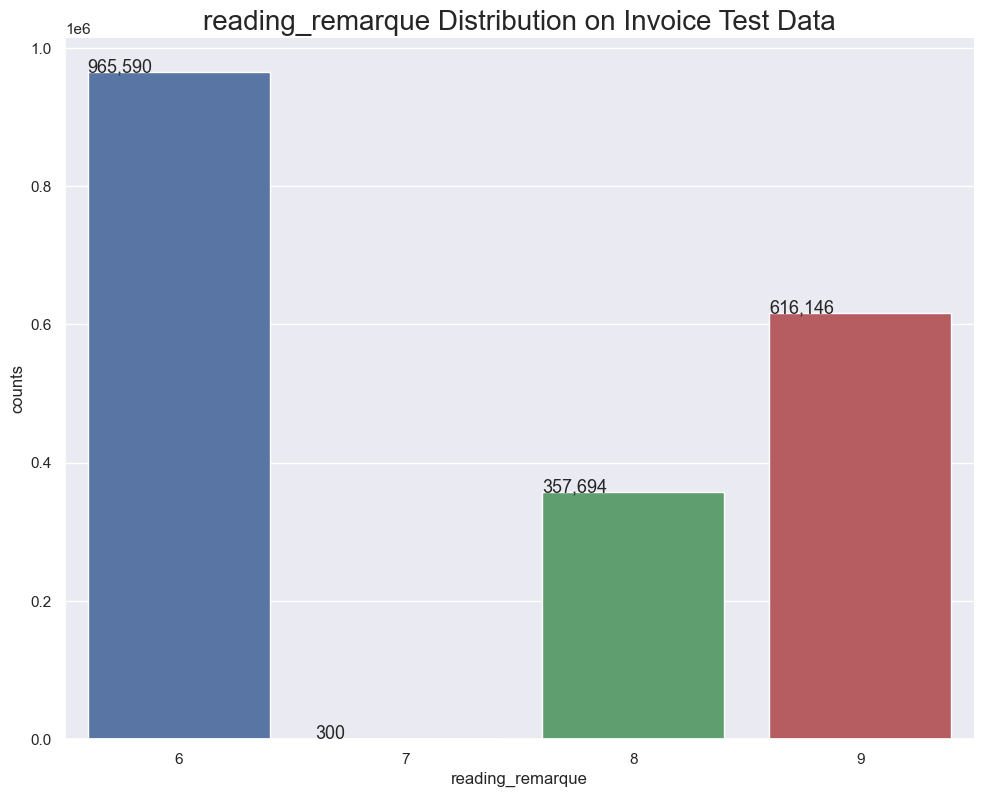

In [10]:
for cate_col in cate_cols:
    df1 = invoice_train[cate_col].value_counts().rename_axis(cate_col).to_frame('counts').reset_index()
    df2 = invoice_test[cate_col].value_counts().rename_axis(cate_col).to_frame('counts').reset_index()
    
    g1 = sns.catplot(x=cate_col,y='counts',kind='bar',data=df1,height = 8, aspect = 1.25)
    g1.ax.set_title(f'{cate_col} Distribution on Invoice Train Data',fontsize=20)
    for p in g1.ax.patches:
        txt = f'{p.get_height() :,.0f}'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g1.ax.text(txt_x,txt_y,txt, size=13)
    
    figure1 = g1.fig   
    figure1.savefig(f'{cate_col} Distribution on Invoice Train Data.jpg',format='jpeg',
                   dpi=100,
                   bbox_inches='tight')


    g2 = sns.catplot(x=cate_col,y='counts',kind='bar',data=df2,height = 8, aspect = 1.25)
    g2.ax.set_title(f'{cate_col} Distribution on Invoice Test Data',fontsize=20)
    for p in g2.ax.patches:
        txt = f'{p.get_height() :,.0f}'
        txt_x = p.get_x()
        txt_y = p.get_height()
        g2.ax.text(txt_x,txt_y,txt, size=13)
        
    figure2 = g2.fig   
    figure2.savefig(f'{cate_col} Distribution on Invoice Test Data.jpg',format='jpeg',
                   dpi=100,
                   bbox_inches='tight')

# Wrong Month Number

In [11]:
invoice_train_month = invoice_train['months_number'].value_counts().rename_axis('month_number').to_frame('counts').reset_index()
invoice_test_month = invoice_test['months_number'].value_counts().rename_axis('month_number').to_frame('counts').reset_index()

In [12]:
invoice_train_month.tail()

,month_number,counts
1365,430834,1
1366,179002,1
1367,186166,1
1368,81499,1
1369,463554,1


In [13]:
invoice_test_month.tail()

,month_number,counts
909,11467,1
910,16031,1
911,6198,1
912,2169,1
913,26699,1


In [14]:
month_error_sample = invoice_train[invoice_train['client_id']=='train_Client_100551'].sort_values(by=['counter_type','invoice_date'])

In [15]:
month_error_sample[['client_id', 'invoice_date', 'counter_number','old_index',
       'new_index', 'months_number', 'counter_type']]

,client_id,invoice_date,counter_number,old_index,new_index,months_number,counter_type
20214,train_Client_100551,2009-03-09,1099471,0,495,3311,ELEC
20219,train_Client_100551,2009-11-05,1099471,0,342,495,ELEC
20212,train_Client_100551,2010-06-05,1099471,0,9971,17815,ELEC
20213,train_Client_100551,2010-08-01,1099471,0,3311,9971,ELEC
20211,train_Client_100551,2010-08-30,1099471,0,17815,25778,ELEC
20215,train_Client_100551,2011-03-14,1099471,0,25778,25778,ELEC
20220,train_Client_100551,2011-08-09,545768,0,6828,8,ELEC
20217,train_Client_100551,2012-09-01,545768,6828,17146,4,ELEC
20218,train_Client_100551,2014-06-05,545768,20841,20841,6,ELEC
20216,train_Client_100551,2017-04-27,545768,20842,20842,30,ELEC


In [16]:
idx = month_error_sample['months_number']>100
month_error_sample.loc[idx,['old_index','new_index']] = month_error_sample.loc[idx,['new_index','months_number']].values
month_error_sample.loc[idx,['months_number']] = 4
month_error_sample.loc[month_error_sample['months_number']==0,['months_number']] = 4

In [17]:
month_error_sample[['client_id', 'invoice_date', 'counter_number','old_index',
       'new_index', 'months_number', 'counter_type']]

,client_id,invoice_date,counter_number,old_index,new_index,months_number,counter_type
20214,train_Client_100551,2009-03-09,1099471,495,3311,4,ELEC
20219,train_Client_100551,2009-11-05,1099471,342,495,4,ELEC
20212,train_Client_100551,2010-06-05,1099471,9971,17815,4,ELEC
20213,train_Client_100551,2010-08-01,1099471,3311,9971,4,ELEC
20211,train_Client_100551,2010-08-30,1099471,17815,25778,4,ELEC
20215,train_Client_100551,2011-03-14,1099471,25778,25778,4,ELEC
20220,train_Client_100551,2011-08-09,545768,0,6828,8,ELEC
20217,train_Client_100551,2012-09-01,545768,6828,17146,4,ELEC
20218,train_Client_100551,2014-06-05,545768,20841,20841,6,ELEC
20216,train_Client_100551,2017-04-27,545768,20842,20842,30,ELEC


# Remove clients with bad counter_statue and remarque in train set

In [18]:
#Remove clients with bad counter_statue and remarque in train set
bad_statue_client = ['train_Client_78338','train_Client_13203','train_Client_53725','train_Client_47780','train_Client_30467']
invoice_train = invoice_train[~invoice_train['client_id'].isin(bad_statue_client)]
invoice_train = invoice_train[~((invoice_train['client_id']=='train_Client_79075') & (invoice_train['counter_type']=='GAZ'))].reset_index(drop=True)

client_train = client_train[~client_train['client_id'].isin(bad_statue_client)].reset_index(drop=True)

# Prepare Client Data

In [19]:
client_test.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [20]:
def prepare_client(df,Train=True):
        
    df['creation_date'] = pd.to_datetime(df['creation_date'],dayfirst=True)
    df['creation_day'] = df['creation_date'].dt.day
    df['creation_month'] = df['creation_date'].dt.month
    df['creation_year'] = df['creation_date'].dt.year
    df['duration']=(2022 - df['creation_date'].dt.year)*12 - df['creation_date'].dt.month
    
    df['disrict'] = df['disrict'].astype(str).astype('category')
    df['client_catg'] = df['client_catg'].astype(str).astype('category')
    df['region_group'] =  df['region'].apply(lambda x: 1 if x<=100 else 3 if x>=300 else 2)
    df['region'] = df['region'].astype(str).astype('category')
    
    if Train:
        
        col_seq = ['client_id','disrict','client_catg', 'region','region_group','creation_date',
                   'creation_day','creation_month','creation_year','duration','target']
    else:
        col_seq = ['client_id','disrict','client_catg', 'region','region_group','creation_date',
                   'creation_day','creation_month','creation_year','duration']
    df = df[col_seq]
    
    return df

# Get Client Train Data

In [21]:
client_train = prepare_client(client_train,Train=True)

OneHotEncoding for Categorical Features

In [22]:
ohe = OneHotEncoder(sparse=False,categories='auto')

ohe_columns = []
ohe_cat_cols = ['disrict','client_catg','region']

ohe.fit(client_train[ohe_cat_cols])

OneHotEncoder(sparse=False, sparse_output=False)

In [23]:
for i,c in enumerate(ohe_cat_cols):
    ohe_columns += [f'{c}_{v}' for v in ohe.categories_[i]]
dummy_train = pd.DataFrame(ohe.transform(client_train[ohe_cat_cols]),columns=ohe_columns)

In [24]:
client_train = reduce_mem_usage(pd.concat([client_train.drop(ohe_cat_cols,axis=1),dummy_train],axis=1))
print(client_train.shape)

Mem. usage decreased to 11.50 Mb (72.2% reduction)
(135488, 40)


In [25]:
client_train.head()

,client_id,region_group,creation_date,creation_day,creation_month,creation_year,duration,target,disrict_60,disrict_62,...,region_308,region_309,region_310,region_311,region_312,region_313,region_371,region_372,region_379,region_399
0,train_Client_0,2,1994-12-31,31,12,1994,324,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,train_Client_1,2,2002-05-29,29,5,2002,235,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,train_Client_10,3,1986-03-13,13,3,1986,429,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train_Client_100,2,1996-07-11,11,7,1996,305,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,train_Client_1000,3,2014-10-14,14,10,2014,86,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Get Client Test Data

In [26]:
client_test = prepare_client(client_test,Train=False)

dummy_test = pd.DataFrame(ohe.transform(client_test[ohe_cat_cols]),columns=ohe_columns)

client_test = reduce_mem_usage(pd.concat([client_test.drop(ohe_cat_cols,axis=1),dummy_test],axis=1))
print(client_train.shape)

Mem. usage decreased to  4.82 Mb (72.1% reduction)
(135488, 40)


# Prepare Invoice Data

# Concat Invoice Train and Test

In [27]:
data = pd.concat([invoice_train,invoice_test],axis=0).reset_index(drop=True)
data = reduce_mem_usage(data)
print(data.shape)

Mem. usage decreased to 446.69 Mb (43.0% reduction)
(6416334, 16)


In [28]:
# Adjust Wrong Column Vlues
idx = data['months_number']>100
data.loc[idx,['old_index','new_index']] = data.loc[idx,['new_index','months_number']].values
data.loc[idx,['months_number']] = 4
data.loc[data['months_number']==0,['months_number']] = 4
    
# Adjust Consumption
data['consommation_level_1'] = round(data['consommation_level_1']/data['months_number'],0)
data['consommation_level_2'] = round(data['consommation_level_2']/data['months_number'],0)
data['consommation_level_3'] = round(data['consommation_level_3']/data['months_number'],0)
data['consommation_level_4'] = round(data['consommation_level_4']/data['months_number'],0)

In [29]:
# Adjust Column Type
data['invoice_date'] = pd.to_datetime(data['invoice_date'])

#data['tarif_type'] = data['tarif_type'].astype(str)
data['tarif_type_str'] = data['tarif_type'].astype(str)

#data['counter_number'] = data['counter_number'].astype(str)

data['counter_statue'] = data['counter_statue'].astype(str)
data['counter_statue_str'] = data['counter_statue']

#data['counter_code'] = data['counter_code'].astype(str)
data['counter_code_str'] = data['counter_code'].astype(str)

#data['reading_remarque'] = data['reading_remarque'].astype(str)
data['reading_remarque_str'] = data['reading_remarque'].astype(str)

In [30]:
# Helper Column for Counter Type Split
data['GAZ']='GAZ'
data['ELEC']='ELEC'

# Feature Engineering

# Add Time Features

In [31]:
data['invoice_date_day'] = data['invoice_date'].dt.day
data['invoice_date_month'] = data['invoice_date'].dt.month
data['invoice_date_year'] = data['invoice_date'].dt.year

# Add Diff Features

In [32]:
data['index_diff'] = data['new_index']-data['old_index']

In [33]:
data['invoice_diff']=data.sort_values(by=['client_id','counter_type','invoice_date']).groupby(['client_id','counter_type'])['invoice_date'].diff().dt.days
data['con_1_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_1'].diff()
data['con_2_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_2'].diff()
data['con_3_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_3'].diff()
data['con_4_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['consommation_level_4'].diff()
data['index_diff_diff']=data.sort_values(by=['client_id','counter_type','counter_number','old_index']).groupby(['client_id','counter_type','counter_number'])['index_diff'].diff()

# Interaction Columns

In [34]:
data['number_plus_code'] = data['counter_number'] + data['counter_code']
data['number_minus_code'] = data['counter_number'] - data['counter_code']
data['number_multi_code'] = data['counter_number'] * data['counter_code']
data['number_div_code'] = data['counter_number'] / data['counter_code']

# Feature Aggregation

In [35]:
# Create base dataframe for aggregation
base = data[['client_id','ELEC','GAZ']].drop_duplicates()
# Create helper columns for quick mapping
base['ELEC'] = list(zip(base['client_id'],base['ELEC']))
base['GAZ'] = list(zip(base['client_id'],base['GAZ']))

In [36]:
base.shape

(193557, 3)

In [37]:
num_feature = ['consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4',
               'old_index','new_index','number_plus_code','number_minus_code','number_multi_code','number_div_code']

num_diff_feature = ['invoice_diff','con_1_diff','con_2_diff','con_3_diff','con_4_diff','index_diff_diff']

cate_feature = ['tarif_type', 'counter_number','counter_statue', 'counter_code', 
                'reading_remarque','counter_coefficient',
                'invoice_date_day','invoice_date_month','invoice_date_year']

cate_freq_feature = ['tarif_type_str','counter_statue_str', 'counter_code_str','reading_remarque_str']


# Label Encode Categorical Features

In [38]:
le = LabelEncoder()
for feature in cate_feature:
    le.fit(data[feature])
    data[feature] = le.transform(data[feature])

# Numerical Feature aggregation

In [43]:
#num_feature = ['consommation_level_1']

In [39]:
for feature in (num_feature):
    mean_dict = dict(data.groupby(['client_id','counter_type'])[feature].mean())
    min_dict = dict(data.groupby(['client_id','counter_type'])[feature].min())
    max_dict = dict(data.groupby(['client_id','counter_type'])[feature].max())
    std_dict = dict(data.groupby(['client_id','counter_type'])[feature].std())
    sum_dict = dict(data.groupby(['client_id','counter_type'])[feature].sum())
    for type_ in ['ELEC','GAZ']:
        base[f'{feature}_mean_{type_}'] = base[f'{type_}'].map(mean_dict)
        base[f'{feature}_min_{type_}'] = base[f'{type_}'].map(min_dict)
        base[f'{feature}_max_{type_}'] = base[f'{type_}'].map(max_dict)
        base[f'{feature}_std_{type_}'] = base[f'{type_}'].map(std_dict)
        base[f'{feature}_sum_{type_}'] = base[f'{type_}'].map(sum_dict)
               
        base[f'{feature}_range_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_min_{type_}']
        base[f'{feature}_max_mean_diff_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_mean_{type_}']

# Numerical Diff Feature aggregation

In [40]:
for feature in num_diff_feature:
    mean_dict = dict(data.groupby(['client_id','counter_type'])[feature].mean())
    min_dict = dict(data.groupby(['client_id','counter_type'])[feature].min())
    max_dict = dict(data.groupby(['client_id','counter_type'])[feature].max())
    std_dict = dict(data.groupby(['client_id','counter_type'])[feature].std())
    sum_dict = dict(data.groupby(['client_id','counter_type'])[feature].sum())
    for type_ in ['ELEC','GAZ']:
        base[f'{feature}_mean_{type_}'] = base[f'{type_}'].map(mean_dict)
        base[f'{feature}_min_{type_}'] = base[f'{type_}'].map(min_dict)
        base[f'{feature}_max_{type_}'] = base[f'{type_}'].map(max_dict)
        base[f'{feature}_std_{type_}'] = base[f'{type_}'].map(std_dict)
        base[f'{feature}_sum_{type_}'] = base[f'{type_}'].map(sum_dict)
               
        base[f'{feature}_range_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_min_{type_}']
        base[f'{feature}_max_mean_diff_{type_}'] = base[f'{feature}_max_{type_}'] - base[f'{feature}_mean_{type_}']

# Categorical Feature aggregation

In [41]:
for feature in cate_feature:
    nunique_dict = dict(data.groupby(['client_id','counter_type'])[feature].nunique())
    mode_dict = dict(data.groupby(['client_id','counter_type'])[feature].agg(lambda x: pd.Series.mode(x)[0]))
    for type_ in ['ELEC','GAZ']:
        base[f'{feature}_nunique_{type_}'] = base[f'{type_}'].map(nunique_dict)
        base[f'{feature}_mode_{type_}'] = base[f'{type_}'].map(mode_dict)

# Categorical Feature Frequency Aggregation

In [42]:
# 1. Tarif_type
tarif_group = data.groupby(['client_id','counter_type','tarif_type_str']).agg(Percent=('tarif_type_str', 'count'))
tarif_group = (tarif_group / tarif_group.groupby(level=[0, 1]).transform("sum")).reset_index()

tarif_group=tarif_group.set_index(['client_id','counter_type','tarif_type_str']).stack().unstack([2,1])
tarif_group.columns = tarif_group.columns.map('_'.join)
tarif_group.sort_index(axis=1,inplace=True)
tarif_group=tarif_group.add_prefix('Tarif_Type_').reset_index().drop(columns=['level_1']).fillna(0)

#  2. Counter_statue
statue_group = data.groupby(['client_id','counter_type','counter_statue_str']).agg(Percent=('counter_statue_str', 'count'))
statue_group = (statue_group / statue_group.groupby(level=[0, 1]).transform("sum")).reset_index()

statue_group=statue_group.set_index(['client_id','counter_type','counter_statue_str']).stack().unstack([2,1])
statue_group.columns = statue_group.columns.map('_'.join)
statue_group.sort_index(axis=1,inplace=True)
statue_group=statue_group.add_prefix('Statue_').reset_index().drop(columns=['level_1']).fillna(0)

#  3.  Counter_code  
code_group = data.groupby(['client_id','counter_type','counter_code_str']).agg(Percent=('counter_code_str', 'count'))
code_group = (code_group / code_group.groupby(level=[0, 1]).transform("sum")).reset_index()

code_group=code_group.set_index(['client_id','counter_type','counter_code_str']).stack().unstack([2,1])
code_group.columns = code_group.columns.map('_'.join)
code_group.sort_index(axis=1,inplace=True)
code_group=code_group.add_prefix('Code_').reset_index().drop(columns=['level_1']).fillna(0)

#  4.  Reading_remarque 
rem_group = data.groupby(['client_id','counter_type','reading_remarque_str']).agg(Percent=('reading_remarque_str', 'count'))
rem_group = (rem_group / rem_group.groupby(level=[0, 1]).transform("sum")).reset_index()

rem_group=rem_group.set_index(['client_id','counter_type','reading_remarque_str']).stack().unstack([2,1])
rem_group.columns = rem_group.columns.map('_'.join)
rem_group.sort_index(axis=1,inplace=True)
rem_group=rem_group.add_prefix('Rem_').reset_index().drop(columns=['level_1']).fillna(0)

# Extra Features

In [43]:
#  1. Invoice_Count
count_group=data.groupby(['client_id','counter_type']).size().reset_index(name='Invoice_Count')
count_group=count_group.set_index(['client_id','counter_type']).stack().unstack([2,1])
count_group.columns = count_group.columns.map('_'.join)
count_group = count_group.reset_index().fillna(0)

#  2. Invoice Date Range
invoice_range_group=data.groupby(['client_id','counter_type']).agg(first_date=('invoice_date', np.min),
                                                               last_date=('invoice_date', np.max)).reset_index()

invoice_range_group['date_range'] = (invoice_range_group['last_date']-invoice_range_group['first_date']).dt.days

invoice_range_group=invoice_range_group.set_index(['client_id','counter_type']).stack().unstack([2,1])
invoice_range_group.columns = invoice_range_group.columns.map('_'.join)
invoice_range_group = invoice_range_group.reset_index()

# Combine All Features

In [44]:
df_list = [base, count_group, invoice_range_group, tarif_group,statue_group,code_group, rem_group]
final = df_list[0]
for df_ in df_list[1:]:
    final = final.merge(df_, how='left',on='client_id')

final.drop(columns=['ELEC','GAZ'],inplace=True)
final = reduce_mem_usage(final)

Mem. usage decreased to 185.70 Mb (63.8% reduction)


In [45]:
final.head()

,client_id,consommation_level_1_mean_ELEC,consommation_level_1_min_ELEC,consommation_level_1_max_ELEC,consommation_level_1_std_ELEC,consommation_level_1_sum_ELEC,consommation_level_1_range_ELEC,consommation_level_1_max_mean_diff_ELEC,consommation_level_1_mean_GAZ,consommation_level_1_min_GAZ,...,Code_600_ELEC,Code_65_GAZ,Rem_6_ELEC,Rem_6_GAZ,Rem_7_ELEC,Rem_7_GAZ,Rem_8_ELEC,Rem_8_GAZ,Rem_9_ELEC,Rem_9_GAZ
0,train_Client_0,79.875000,19.0,300.0,76.312500,2796.0,281.0,220.125000,NaN,NaN,...,0.0,0.0,0.600098,0.0,0.0,0.0,0.228516,0.0,0.171387,0.0
1,train_Client_1,129.375000,82.0,194.0,24.000000,4789.0,112.0,64.562500,NaN,NaN,...,0.0,0.0,0.540527,0.0,0.0,0.0,0.162109,0.0,0.297363,0.0
2,train_Client_10,123.812500,47.0,200.0,36.906250,2229.0,153.0,76.187500,NaN,NaN,...,0.0,0.0,0.555664,0.0,0.0,0.0,0.277832,0.0,0.166626,0.0
3,train_Client_100,0.300049,0.0,4.0,0.978516,6.0,4.0,3.699219,NaN,NaN,...,0.0,0.0,0.950195,0.0,0.0,0.0,0.000000,0.0,0.049988,0.0
4,train_Client_1000,173.125000,62.0,200.0,43.343750,2424.0,138.0,26.859375,NaN,NaN,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.142822,0.0,0.856934,0.0


# Split Train and Test

In [46]:
train_invoice_agg = final[final['client_id'].str.contains('train')].reset_index(drop=True)

In [47]:
train_invoice_agg.shape

(135488, 346)

In [48]:
test_invoice_agg = final[final['client_id'].str.contains('test')].reset_index(drop=True)

In [49]:
test_invoice_agg.shape

(58069, 346)

# Merge Invoice and Client

In [50]:
def merge_client_invoice(client,invoice_agg):
    df = client.merge(invoice_agg,how='inner',on='client_id')
    
    df['date_range_ELEC'] = df['date_range_ELEC'].astype('float64')
    df['date_range_GAZ'] = df['date_range_GAZ'].astype('float64')
    df['first_date_ELEC'] = pd.to_datetime(df['first_date_ELEC'])
#   df['creation_date'] = pd.to_datetime(df['creation_date'])
    df['last_date_ELEC'] = pd.to_datetime(df['last_date_ELEC'])
    df['first_date_GAZ'] = pd.to_datetime(df['first_date_GAZ'])
    df['last_date_GAZ'] = pd.to_datetime(df['last_date_GAZ'])
    
    df['first_invoice_gap_ELEC']  = (df['first_date_ELEC']-df['creation_date']).dt.days
    df['last_invoice_gap_ELEC']  = (df['last_date_ELEC']-df['creation_date']).dt.days
    df['first_invoice_gap_GAZ']  = (df['first_date_GAZ']-df['creation_date']).dt.days
    df['last_invoice_gap_GAZ']  = (df['last_date_GAZ']-df['creation_date']).dt.days
    df.drop(columns = ['client_id','first_date_ELEC','last_date_ELEC','first_date_GAZ','last_date_GAZ','creation_date'],inplace=True)
    print(df.shape)
    return df

In [51]:
test_df = merge_client_invoice(client_test,test_invoice_agg)

(58069, 382)


In [52]:
train_df = merge_client_invoice(client_train,train_invoice_agg)

(135488, 383)


In [53]:
train_df.tail()

,region_group,creation_day,creation_month,creation_year,duration,target,disrict_60,disrict_62,disrict_63,disrict_69,...,Rem_7_ELEC,Rem_7_GAZ,Rem_8_ELEC,Rem_8_GAZ,Rem_9_ELEC,Rem_9_GAZ,first_invoice_gap_ELEC,last_invoice_gap_ELEC,first_invoice_gap_GAZ,last_invoice_gap_GAZ
135483,3,26,7,2004,209,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,349.0,5448.0,1310.0,5448.0
135484,3,25,10,2012,110,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.666504,120.0,2427.0,120.0,2427.0
135485,3,22,11,2011,121,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.000000,85.0,2906.0,85.0,1807.0
135486,2,22,12,1993,336,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.5,0.000000,4258.0,4380.0,NaN,NaN
135487,2,18,2,1986,430,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,3628.0,3872.0,NaN,NaN


# Train Baseline Models

In [54]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [55]:
target=train_df['target']
train_df.drop('target',axis=1,inplace=True)

In [56]:
model_dict = {   
                
            
                  'CART': (DecisionTreeClassifier(),
                           {'max_depth': [5,10,100]}),
                           #{'max_depth': [10]}),
              
                  'KNN': (KNeighborsClassifier(),
                          {'n_neighbors': [10,50,100]}),
                          #{'n_neighbors': [10]}),
              
                        
                  'RF': (RandomForestClassifier(),
                         {'n_estimators': [50,100,200,300]})
                         #{'n_estimators': [50]})
             }

In [57]:
results_df = pd.DataFrame(columns=['ROC_AUC'],index=list(model_dict.keys()))
results_df.index.name = 'Model'

In [58]:
for model_name, model_config in model_dict.items():
    print('Model Name：', model_name)
    model = model_config[0]
    parameters = model_config[1]
    
    start_time = time.time()
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=43)
    clf = GridSearchCV(model, parameters, cv=stkfold, scoring='roc_auc')
    clf.fit(train_df,target)
    
    print('Best Parameter:', clf.best_params_)
    print('Best CV： {:.3f}'.format(clf.best_score_))
    
    results_df.loc[model_name] = [clf.best_score_]
    
    print(f"finished after {time.time() - start_time :.2f} seconds")
    print(' ')
    

Model Name： CART
Best Parameter: {'max_depth': 5}
Best CV： 0.851
finished after 629.62 seconds
 
Model Name： KNN
Best Parameter: {'n_neighbors': 100}
Best CV： 0.762
finished after 736.53 seconds
 
Model Name： RF
Best Parameter: {'n_estimators': 300}
Best CV： 0.881
finished after 8982.88 seconds
 


In [60]:
results_df = results_df.reset_index()

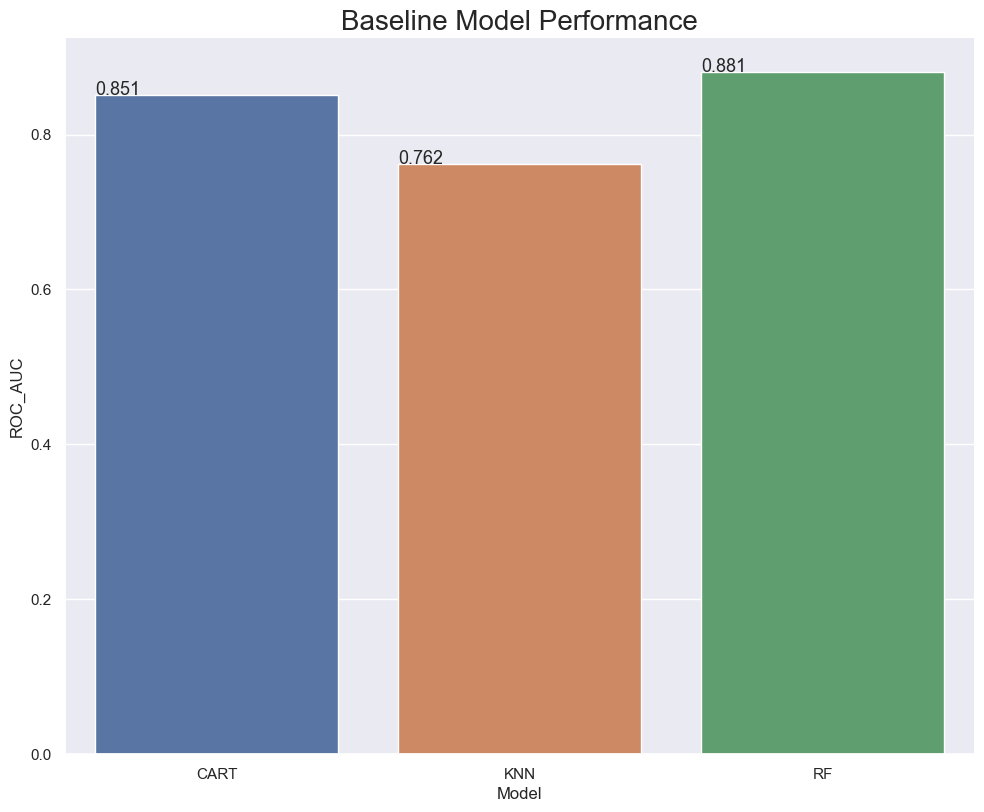

In [61]:
g = sns.catplot(x='Model',y='ROC_AUC',kind='bar',data=results_df,height = 8, aspect = 1.25)
g.ax.set_title(f'Baseline Model Performance',fontsize=20)

for p in g.ax.patches:
    txt = str(p.get_height().round(3))
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt, size=13)

figure = g.fig   
figure.savefig(f'./Model Performance.jpg',format='jpeg',
               dpi=100,
               bbox_inches='tight')